# Advent of code 2025

[[**Open the notebook in Colab**]](https://colab.research.google.com/github/hhoppe/advent_of_code/blob/main/2025/advent_of_code_2025.ipynb)

Jupyter [notebook](https://github.com/hhoppe/advent_of_code/blob/main/2025/advent_of_code_2025.ipynb)
with Python solutions to the
[2025 Advent of Code puzzles](https://adventofcode.com/2025),
completed in December 2025,
by [Hugues Hoppe](https://hhoppe.com/).

The notebook presents both "compact" and "fast" code versions, along with data visualizations.

For the fast solutions, the [cumulative time](#timings) across all 12 puzzles is less than 0.5 s on my PC.<br/>
(Some solutions use the `numba` package to jit-compile functions, which can take a few seconds.)

<p>
 <a href="#day4">day4</a>
 <img src="results/day04.gif" width="250">&emsp;
 <a href="#day7">day7</a>
 <img src="results/day07.gif" width="250">&emsp;
</p>

<p>
 <a href="#day8">day8</a>
 <img src="results/day08a.png" width="220">&nbsp;
 <img src="results/day08b.png" width="220">&emsp;
 <a href="#day9">day9</a>
 <img src="results/day09.png" width="220">
</p>

<p>
 <a href="#day11">day11</a>
 <img src="results/day11.png" width="440">
</p>

<a name="preamble"></a>
## Preamble

In [1]:
!command -v ffmpeg >/dev/null || (apt-get -qq update && apt-get -qq -y install ffmpeg) >/dev/null  # For mediapy.

In [2]:
!dpkg -l | grep -q libgraphviz-dev || (apt-get -qq update && apt-get -qq -y install libgraphviz-dev) >/dev/null  # https://stackoverflow.com/a/66380001

In [3]:
!pip install -q advent-of-code-hhoppe hhoppe-tools matplotlib mediapy \
  networkx numba numpy pygraphviz scipy

In [4]:
import bisect
import collections
from collections.abc import Callable
import functools
import itertools
import math
import pathlib
import re
from typing import Any

import advent_of_code_hhoppe  # https://github.com/hhoppe/advent-of-code-hhoppe/blob/main/advent_of_code_hhoppe/__init__.py
import hhoppe_tools as hh  # https://github.com/hhoppe/hhoppe-tools/blob/main/hhoppe_tools/__init__.py
import matplotlib.pyplot as plt
import mediapy as media  # https://github.com/google/mediapy/blob/main/mediapy/__init__.py
import networkx
import numba
import numpy as np
import scipy.optimize
import scipy.spatial.distance
import z3

In [5]:
if not media.video_is_available():
  media.show_videos = lambda *a, **kw: print('Creating video is unavailable.')

In [6]:
if pathlib.Path('results').is_dir():
  media.set_show_save_dir('results')

In [7]:
hh.start_timing_notebook_cells()

In [8]:
YEAR = 2025
PROFILE = 'google.Hugues_Hoppe.965276'
# PROFILE = 'github.hhoppe.1452460'
# echo 53616... >~/.config/aocd/token  # session cookie from "adventofcode.com" (valid 1 month).

In [9]:
TAR_URL = f'https://github.com/hhoppe/advent_of_code/raw/main/{YEAR}/data/{PROFILE}.tar.gz'
TAR_URL = ''
advent = advent_of_code_hhoppe.Advent(year=YEAR, tar_url=TAR_URL)

In [10]:
hh.adjust_jupyterlab_markdown_width()

### Helper functions

In [11]:
check_eq = hh.check_eq

In [12]:
_ORIGINAL_GLOBALS = list(globals())

<a name="day1"></a>
## Day 1: Combination dial

- Part 1: The actual password is the number of times the dial is left pointing at 0 after any rotation in the sequence.  What's the actual password to open the door?

- Part 2: Count the number of times any click causes the dial to point at 0, regardless of whether it happens during a rotation or at the end of one.

In [13]:
puzzle = advent.puzzle(day=1)

For [day 1](https://adventofcode.com/2025/day/1), `puzzle.input` has 4_099 lines:

R10
L39
L30
L9
R28
L27
R14
L48
 ...
R26
L21
L1
R14


The stored answers are: `{1: '995', 2: '5847'}`

In [14]:
s1 = """\
L68
L30
R48
L5
R60
L55
L1
L99
R14
L82
"""

In [15]:
def day1(s, *, part2=False, size=100, state=50):
  total = 0
  for line in s.splitlines():
    direction, abs_num_steps = line[0], int(line[1:])
    signed_num_steps = dict(L=-1, R=1)[direction] * abs_num_steps
    if part2:
      if signed_num_steps > 0:
        total += (state + signed_num_steps - 1) // size - state // size
      elif signed_num_steps < 0:
        total += (state - 1) // size - (state + signed_num_steps) // size
    state = (state + signed_num_steps) % size
    total += state == 0

  return total


check_eq(day1(s1), 3)
puzzle.verify(1, day1)

day1_part2 = functools.partial(day1, part2=True)
check_eq(day1_part2(s1), 6)
puzzle.verify(2, day1_part2)

(Part 1: 0.001 s)
(Part 2: 0.002 s)


<a name="day2"></a>
## Day 2: Repeated substrings

- Part 1: You can find the invalid IDs by looking for any ID which is made only of some sequence of digits repeated twice.  What do you get if you add up all of the invalid IDs?

- Part 2: Now, an ID is invalid if it is made only of some sequence of digits repeated at least twice.

In [16]:
puzzle = advent.puzzle(day=2)

For [day 2](https://adventofcode.com/2025/day/2), `puzzle.input` has a single line of 504 characters:

288352-412983,743179-799185,7298346751-7298403555,3269-7729,3939364590-393943345 ... 411975,7778-14058,83706740-83939522


The stored answers are: `{1: '40055209690', 2: '50857215650'}`

In [17]:
s1 = """\
11-22,95-115,998-1012,1188511880-1188511890,222220-222224,
1698522-1698528,446443-446449,38593856-38593862,565653-565659,
824824821-824824827,2121212118-2121212124
"""

In [18]:
# Slow string-based solution.
def day2a(s, *, part2=False):

  def is_matching(string):
    if not part2:
      half_len = len(string) // 2
      return string[:half_len] == string[half_len:]

    for part_len in range(1, len(string) // 2 + 1):
      div, mod = divmod(len(string), part_len)
      if mod == 0 and string[:part_len] * div == string:
        return True

    return False

  total = 0
  for range_ in s.strip().replace('\n', '').split(','):
    lo, hi = map(int, range_.split('-'))
    for value in range(lo, hi + 1):
      string = str(value)
      if is_matching(string):
        total += value

  return total


check_eq(day2a(s1), 1227775554)
# puzzle.verify(1, day2a)

day2a_part2 = functools.partial(day2a, part2=True)
check_eq(day2a_part2(s1), 4174379265)
# puzzle.verify(2, day2a_part2)

In [19]:
# Arithmetic solution.  E.g., a 6-digit value consists of a repeated digit sequence (of
# length 1, 2, or 3) iff it is divisible by 111111, 10101, or 1001, respectively.
# For each value in the range, we test if it is a multiple of any divisor.
@numba.njit
def day2b_total(start: int, stop: int, part2: bool) -> int:
  """Sum the values whose decimal digits form a repeated span."""
  num_digits = math.floor(math.log10(start)) + 1
  divisors = [
      (10**num_digits - 1) // (10**part_len - 1)
      for part_len in range(1, num_digits)
      if num_digits % part_len == 0 and (part_len * 2 == num_digits or part2)
  ]
  total = 0
  for value in range(start, stop):
    for divisor in divisors:
      if value % divisor == 0:
        total += value
        break

  return total


def day2b(s, *, part2=False):

  def split_by_num_digits(start, stop):
    """Partition an integer range into subranges with the same number of digits."""
    while start < stop:
      end = min(10 ** (math.floor(math.log10(start)) + 1), stop)
      yield start, end
      start = end

  total = 0
  for range_ in s.strip().replace('\n', '').split(','):
    lo, hi = map(int, range_.split('-'))
    for start, stop in split_by_num_digits(lo, hi + 1):
      total += day2b_total(start, stop, part2)

  return total


check_eq(day2b(s1), 1227775554)
puzzle.verify(1, day2b)

day2b_part2 = functools.partial(day2b, part2=True)
check_eq(day2b_part2(s1), 4174379265)
puzzle.verify(2, day2b_part2)

(Part 1: 0.007 s)
(Part 2: 0.010 s)


In [20]:
# Arithmetic solution.  E.g., a 6-digit value consists of a repeated digit sequence (of
# length 1, 2, or 3) iff it is divisible by 111111, 10101, or 1001, respectively.
# We gather the set of all divisor multiples inside the specified range.
def day2(s, *, part2=False):

  def split_by_num_digits(start, stop):
    """Partition an integer range into subranges with the same number of digits."""
    while start < stop:
      end = min(10 ** (math.floor(math.log10(start)) + 1), stop)
      yield start, end
      start = end

  total = 0
  for lo, hi in re.findall(r'(\d+)-(\d+)', s):
    for start, stop in split_by_num_digits(int(lo), int(hi) + 1):
      num_digits = math.floor(math.log10(start)) + 1
      divisors = [
          (10**num_digits - 1) // (10**p - 1)
          for p in range(1, num_digits)
          if num_digits % p == 0 and (p * 2 == num_digits or part2)
      ]
      values = set[int]()
      for d in divisors:
        values.update(range(-(-start // d) * d, (stop - 1) // d * d + 1, d))
      total += sum(values)

  return total


check_eq(day2(s1), 1227775554)
puzzle.verify(1, day2)

day2_part2 = functools.partial(day2, part2=True)
check_eq(day2_part2(s1), 4174379265)
puzzle.verify(2, day2_part2)

(Part 1: 0.000 s)
(Part 2: 0.000 s)


<a name="day3"></a>
## Day 3: Largest subsequence

- Part 1: For each line, compute the max integer formed by exactly two (ordered) digits from the line.  What is the sum?

- Part 2: Same but using 12 ordered digits?

In [21]:
puzzle = advent.puzzle(day=3)

For [day 3](https://adventofcode.com/2025/day/3), `puzzle.input` has 200 lines:

2232546378857275787561723292343835435343333776427842773354273372424413455462238746648634437374254318
2232323232236223322223321222232212221212222222222332111132223222222222322133213322323133322222332224
5345633566354453355546874555676462558526423364443535432344223165523377525665661379556365535642545245
3312322113352322342133434233342422313224135342333232234332332232313223352233232336232233533323364322
7437646373353235155735343435554333431433443536224555522543536551333362632825253343285513535558325854
3222123322227233223132632222232453272112312222122223422132223116232333212237823142211222237524323222
4465534231252534253434245275245235354423242313443332433122622233225354322454422331144344533452137366
2323665242312255512231224363222522323532325833542132254227637325255425546234462234351151232235565134
 ...
2433733322122313275322425557825226339325552533247133133749552235546742511874255634664556254127332373
35229422233226452271529249236628234155422422413325588323445332127923443246255372661635

The stored answers are: `{1: '17196', 2: '171039099596062'}`

In [22]:
s1 = """\
987654321111111
811111111111119
234234234234278
818181911112111
"""

In [23]:
# O(N^2) solution; still fast.
def day3a(s, *, part2=False):
  # For each line, find largest k-length subsequence (as a number).
  k = (2, 12)[part2]
  total = 0

  for line in s.splitlines():
    digits = list(map(int, line))
    index = -1
    stop_index = len(digits) - k + 1
    value = 0
    for _ in range(k):
      index = max(range(index + 1, stop_index), key=lambda i: digits[i])
      value = value * 10 + digits[index]
      stop_index += 1

    total += value

  return total


check_eq(day3a(s1), 357)
puzzle.verify(1, day3a)

day3a_part2 = functools.partial(day3a, part2=True)
check_eq(day3a_part2(s1), 3121910778619)
puzzle.verify(2, day3a_part2)

(Part 1: 0.002 s)
(Part 2: 0.004 s)


In [24]:
# O(N + k) solution.
def day3(s, *, part2=False):
  # For each line, find largest k-length subsequence (as a number).
  k = (2, 12)[part2]
  total = 0

  for line in s.splitlines():
    n = len(line)
    result: list[str] = []
    for i, digit in enumerate(line):
      # Pop smaller digits if we can still form k-length result.
      while result and result[-1] < digit and len(result) + (n - i) > k:
        result.pop()
      if len(result) < k:
        result.append(digit)
    total += int(''.join(result))

  return total


check_eq(day3(s1), 357)
puzzle.verify(1, day3)

day3_part2 = functools.partial(day3, part2=True)
check_eq(day3_part2(s1), 3121910778619)
puzzle.verify(2, day3_part2)

(Part 1: 0.002 s)
(Part 2: 0.003 s)


<a name="day4"></a>
## Day 4: Cellular automaton

- Part 1: What is the number of defined cells with fewer than 4 (out of 8) defined neighbors?

- Part 2: We iteratively remove all cells satisfying the condition in part1.  What is the total number of cells removed?

In [25]:
puzzle = advent.puzzle(day=4)

For [day 4](https://adventofcode.com/2025/day/4), `puzzle.input` has 139 lines:

@@@..@@@.@.@.@@@..@@@@@@@@@@@@@..@.....@@.@.@@@.@@@..@@@@@@@@..@..@@@@.@.@@@@@@. ... @@@@@.@.@@.@@@@@@.@.@.@@...@@@@@@..
@.@@.@.....@.@@@@@.@..@.@.@@@.@.@.@..@..@@@.@@..@@@.@@....@@@@.@@@..@@..@@@@.@@@ ... @@@.@@@@@.@...@@..@@@@@..@@@@@.@@..
@@@@..@@.....@@@@.@.@@@.@.@.@@@@@@@.@@.@@@@@.@@.@..@..@@..@@...@@@@..@@@@...@@@@ ... @@..@.@@.@@@..@.@@.@@@.@@..@@..@@@.
@.....@.@@@@@...@@@.@@@@@@@..@.@@.@.@@@@@@@@..@.@.@@@@@@.@.@@.@.@@@@@@.@..@@@.@@ ... @..@.@@@..@@...@@@.@@@@@.@..@@.@.@@
@@@@.@@@@@@.@...@..@@..@@..@@.@@@@@...@@.@.@@@.@@...@@.@.@@@@..@.@@@.@.@@@@@@.@@ ... @@..@@@@@@@.@@..@@@@.@@@@@@.@@@@@..
@@@..@@@.@@@..@@.@@.@@@@@@.@@..@...@@.@.@@@@@@@@@@@.@@@...@@..@@.@.@.@@.@@.@@..@ ... .@@@@..@@.@@@@..@.@.@@.@@@@..@@@@@@
.@@.@.@@@.@@..@@@@@.@@.@@@@..@.@@.@@@.@@...@.@..@.@@.@.@..@@.@@@.@@.@@.@@@@.@@@@ ... .@@@...@..@....@@.@@@.@@@@.@@.@@@.@
.@..@..@@@.@@.@@......@@@@@.@@@@@.@@@@.@.@@.@@@@@@..@.@.@..@.@@@@@@....@...@.@.@ ... ......@.@@@.@.@..@@@@@@@.@.......@@
 ...
@@.@@@@@@@@@@.@@@@.@@@@..@@

The stored answers are: `{1: '1409', 2: '8366'}`

In [26]:
s1 = """\
..@@.@@@@.
@@@.@.@.@@
@@@@@.@.@@
@.@@@@..@.
@@.@@@@.@@
.@@@@@@@.@
.@.@.@.@@@
@.@@@.@@@@
.@@@@@@@@.
@.@.@@@.@.
"""

In [27]:
def day4a_part1(s):
  grid = np.array([list(line) for line in s.splitlines()]) == '@'
  grid = np.pad(grid, 1)
  neighbors = set(itertools.product((-1, 0, 1), repeat=2)) - {(0, 0)}
  num_neighbors = np.add.reduce([np.roll(grid, yx, axis=(0, 1)) for yx in neighbors])
  return (grid & (num_neighbors < 4)).sum()


check_eq(day4a_part1(s1), 13)
puzzle.verify(1, day4a_part1)

(Part 1: 0.002 s)


In [28]:
def day4(s, *, part2=False):
  grid = np.pad(np.array([list(line) for line in s.splitlines()]) == '@', 1)
  neighbors = set(itertools.product((-1, 0, 1), repeat=2)) - {(0, 0)}
  total_removed = 0

  while True:
    num_neighbors = np.add.reduce([np.roll(grid, yx, axis=(0, 1)) for yx in neighbors])
    to_remove = grid & (num_neighbors < 4)
    num_removed = to_remove.sum()
    total_removed += num_removed
    if num_removed == 0 or not part2:
      break
    grid[to_remove] = False

  return total_removed


check_eq(day4(s1), 13)
puzzle.verify(1, day4)

day4_part2 = functools.partial(day4, part2=True)
check_eq(day4_part2(s1), 43)
puzzle.verify(2, day4_part2)

(Part 1: 0.002 s)
(Part 2: 0.009 s)


day04

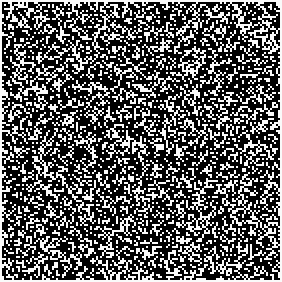

In [29]:
def day4_visualize(s, rep=2, fps=10):
  grid = np.pad(np.array([list(line) for line in s.splitlines()]) == '@', 1)
  neighbors = set(itertools.product((-1, 0, 1), repeat=2)) - {(0, 0)}

  as_image = lambda grid: hh.to_image(grid.repeat(rep, 0).repeat(rep, 1), 250, 0)
  images = [as_image(grid)]

  while True:
    num_neighbors = np.add.reduce([np.roll(grid, yx, axis=(0, 1)) for yx in neighbors])
    to_remove = grid & (num_neighbors < 4)
    if not np.any(to_remove):
      break
    grid[to_remove] = False
    images.append(as_image(grid))

  images = [images[0]] * fps + images + [images[-1]] * fps
  media.show_video(images, codec='gif', fps=fps, title='day04')


day4_visualize(puzzle.input)

<a name="day5"></a>
## Day 5: Overlapping intervals

- Part 1: How many of the specified elements are contained in any interval?

- Part 2: How many unique elements are in the union of all the intervals?

In [30]:
puzzle = advent.puzzle(day=5)

For [day 5](https://adventofcode.com/2025/day/5), `puzzle.input` has 1_196 lines:

291687894568177-292172488078380
427870047590103-428717994993731
265654071674500-266942022274189
153971257711624-156206755538956
533206775741152-538581383901374
513693225083242-518339086307594
81406311055957-87395321431072
517429407132374-522476734966169
 ...
348960509485771
217968120085950
276730725242866
168500356124728


The stored answers are: `{1: '720', 2: '357608232770687'}`

In [31]:
s1 = """\
3-5
10-14
16-20
12-18

1
5
8
11
17
32
"""

In [32]:
def day5(s, *, part2=False, optimized_part1=True):
  s_intervals, s_indices = s.split('\n\n')

  input_intervals = []
  for line in s_intervals.splitlines():
    start, end = map(int, line.split('-'))
    input_intervals.append((start, end + 1))

  indices = list(map(int, s_indices.splitlines()))

  # Sort the intervals and merge adjacent or overlapping intervals.
  intervals: list[tuple[int, int]] = []
  for start, stop in sorted(input_intervals):
    if not intervals or start > intervals[-1][1]:
      intervals.append((start, stop))
    elif stop > intervals[-1][1]:
      intervals[-1] = intervals[-1][0], stop

  if part2:
    return sum(stop - start for start, stop in intervals)

  if not optimized_part1:
    return sum(any(start <= index < stop for start, stop in intervals) for index in indices)

  count = 0
  for index in indices:
    i = bisect.bisect_left(intervals, index, key=lambda interval: interval[0])
    if i > 0:
      start, stop = intervals[i - 1]
      count += start <= index < stop
  return count


check_eq(day5(s1), 3)
puzzle.verify(1, day5)

day5_part2 = functools.partial(day5, part2=True)
check_eq(day5_part2(s1), 14)
puzzle.verify(2, day5_part2)

(Part 1: 0.001 s)
(Part 2: 0.000 s)


<a name="day6"></a>
## Day 6: Ops on tabular digits

- Part 1: Apply multiplication or addition on each column of numbers.  What is the total of these results?

- Part 2: Each number is now represented by the digits in a column.  What is the total of the results?

In [33]:
puzzle = advent.puzzle(day=6)

For [day 6](https://adventofcode.com/2025/day/6), `puzzle.input` has 5 lines:

5  679 21 1766 81 75  16 993 2897 28 534 9545 5  5922 63  6 732 569 579 727 63 5 ...  266 715 49 92 64 51  14 645  5 632
5  847 87  277 81 51  62  98 823  64 254  144 37 3422 1   1 636 778 546 317 98 8 ...  857 21  22 45 33 273 49 972  1 875
61 86  49  467 38 211 37  55 3    38 945  644 94  394 3  52 535 977 923 875 24 8 ...  111 85  25 24 23 511 34 718  7  39
62 3   73   51 77 483 23  49 8     5   3    5 95  634 3  77 379 915 337 714 56 8 ...  148 7   66 83  5 951 27  29 74   9
+  *   *  +    +  *   +  +   +    *  +   +    *  +    *  +  *   *   *   *   +  + ...  *   *   *  *  +  *   +  +   +  *  


The stored answers are: `{1: '4076006202939', 2: '7903168391557'}`

In [34]:
s1 = """\
123 328  51 64 EOL
 45 64  387 23 EOL
  6 98  215 314EOL
*   +   *   +  EOL
""".replace(
    'EOL', ''
)

In [35]:
def day6_part1(s):
  lines = s.splitlines()
  array = np.array(list(line.split() for line in lines[:-1]), int)
  operations = lines[-1].split()
  total = 0

  ops: dict[str, Callable[..., Any]] = {'*': np.prod, '+': np.sum}
  for column, operation in zip(array.T, operations):
    total += ops[operation](column)

  return total


check_eq(day6_part1(s1), 4277556)
puzzle.verify(1, day6_part1)

(Part 1: 0.002 s)


In [36]:
def day6_part2(s):
  lines = [line + ' ' for line in s.splitlines()]
  assert all(len(line) == len(lines[0]) for line in lines)
  ops: dict[str, Callable[..., Any]] = {'*': np.prod, '+': np.sum}
  op: Callable[..., Any] | None = None
  values: list[int] = []
  total = 0

  for i, ch in enumerate(lines[-1]):
    if ch != ' ':
      op = ops[ch]
    digits = [digit for line in lines[:-1] if (digit := line[i]) != ' ']
    if digits:
      values.append(int(''.join(digits)))
    else:
      assert op
      total += op(values)
      values = []

  return total


check_eq(day6_part2(s1), 3263827)
puzzle.verify(2, day6_part2)

(Part 2: 0.004 s)


<a name="day7"></a>
## Day 7: Beam splitter

- Part 1: How many times will the beam be split?

- Part 2: In total, how many different timelines would a single tachyon particle end up on?

In [37]:
puzzle = advent.puzzle(day=7)

For [day 7](https://adventofcode.com/2025/day/7), `puzzle.input` has 142 lines:

......................................................................S......... ... ...................................
................................................................................ ... ...................................
......................................................................^......... ... ...................................
................................................................................ ... ...................................
.....................................................................^.^........ ... ...................................
................................................................................ ... ...................................
....................................................................^.^.^....... ... ...................................
................................................................................ ... ...................................
 ...
..^.^.^.^.^.^.^.^.......^..

The stored answers are: `{1: '1560', 2: '25592971184998'}`

In [38]:
s1 = """\
.......S.......
...............
.......^.......
...............
......^.^......
...............
.....^.^.^.....
...............
....^.^...^....
...............
...^.^...^.^...
...............
..^...^.....^..
...............
.^.^.^.^.^...^.
...............
"""

In [39]:
def day7_part1(s):
  grid = np.array([list(line) for line in s.splitlines()])
  ((start_y, start_x),) = np.argwhere(grid == 'S')
  set_x = {start_x}
  num_splits = 0

  for y in range(start_y + 1, grid.shape[0]):
    new_set_x = set()

    for x in set_x:
      if grid[y, x] == '^':
        assert 0 < x < grid.shape[1] - 1
        new_set_x |= {x - 1, x + 1}
        num_splits += 1
      else:
        new_set_x |= {x}

    set_x = new_set_x

  return num_splits


check_eq(day7_part1(s1), 21)
puzzle.verify(1, day7_part1)

(Part 1: 0.004 s)


In [40]:
def day7_part2(s):
  grid = np.array([list(line) for line in s.splitlines()])
  ((start_y, start_x),) = np.argwhere(grid == 'S')
  Counter = collections.Counter[int]
  counter = Counter({start_x: 1})

  for y in range(start_y + 1, grid.shape[0]):
    new_counter = Counter()

    for x, count in counter.items():
      if grid[y, x] == '^':
        assert 0 < x < grid.shape[1] - 1
        new_counter += Counter({x - 1: count, x + 1: count})
      else:
        new_counter += Counter({x: count})

    counter = new_counter

  return counter.total()


check_eq(day7_part2(s1), 40)
puzzle.verify(2, day7_part2)

(Part 2: 0.016 s)


day07

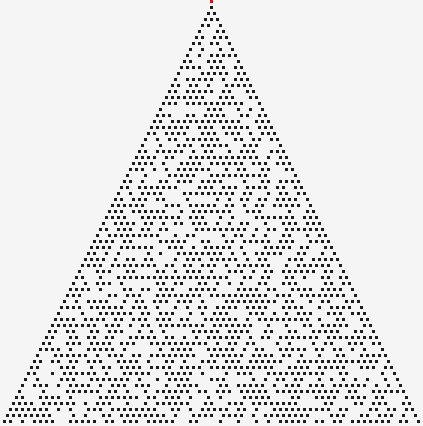

In [41]:
def day7_visualize(s, rep=3, fps=30):
  grid = np.array([list(line) for line in s.splitlines()])
  ((start_y, start_x),) = np.argwhere(grid == 'S')
  Counter = collections.Counter[int]
  counter = Counter({start_x: 1})
  cmap = {'.': (245, 245, 245), 'S': (255, 0, 0), '^': (30, 30, 30)}
  image = np.array([cmap[e] for e in grid.flat], np.uint8).reshape(*grid.shape, 3)
  images = [image.copy()]

  for y in range(start_y + 1, grid.shape[0]):
    new_counter = Counter()

    for x, count in counter.items():
      if grid[y, x] == '^':
        assert 0 < x < grid.shape[1] - 1
        new_counter += Counter({x - 1: count, x + 1: count})
      else:
        new_counter += Counter({x: count})

    counter = new_counter
    for x, count in counter.items():
      image[y, x] = 130, 130, 240
    images.append(image.copy())

  images = [images[0]] * fps + images + [images[-1]] * fps
  images = [image.repeat(rep, 0).repeat(rep, 1) for image in images]
  media.show_video(images, codec='gif', fps=fps, title='day07')


day7_visualize(puzzle.input)

<a name="day8"></a>
## Day 8: Components on 3D points

- Part 1: After inserting the 1000 shortest edges, what is the product of the sizes of the largest 3 connected components?

- Part 2: Keep inserting edges by sorted length until a single component is formed.  For that final edge, what is the product of the X coordinates of the edge endpoints?

In [42]:
puzzle = advent.puzzle(day=8)

For [day 8](https://adventofcode.com/2025/day/8), `puzzle.input` has 1_000 lines:

62520,94824,58185
1881,64809,15856
26905,48605,19448
40769,80814,81090
21439,52625,45591
6199,78564,6862
94793,22297,51994
83965,28443,98203
 ...
64062,5030,7649
42777,35963,62565
41510,29393,89118
9817,36168,82381


The stored answers are: `{1: '140008', 2: '9253260633'}`

In [43]:
s1 = """\
162,817,812
57,618,57
906,360,560
592,479,940
352,342,300
466,668,158
542,29,236
431,825,988
739,650,466
52,470,668
216,146,977
819,987,18
117,168,530
805,96,715
346,949,466
970,615,88
941,993,340
862,61,35
984,92,344
425,690,689
"""

In [44]:
def day8(s, *, part2=False, num_edges=1000):
  points = np.array([list(map(int, line.split(','))) for line in s.splitlines()])

  # Compute all pairwise distances.
  dists = scipy.spatial.distance.pdist(points)  # Condensed edge index -> pairwise distance.
  ij_of_index = np.column_stack(np.triu_indices(len(points), k=1))  # Condensed edge index -> i, j.

  union_find = hh.UnionFind[int]()

  if not part2:
    smallest_index = np.argpartition(dists, num_edges)[:num_edges]
    smallest_index = smallest_index[np.argsort(dists[smallest_index])]

    for edge_index in smallest_index:
      i, j = ij_of_index[edge_index]
      union_find.union(i, j)

    labels = [union_find.find(i) for i in range(len(points))]
    _, counts = np.unique(labels, return_counts=True)
    return np.prod(np.sort(counts)[-3:])

  sorted_edge_indices = np.argsort(dists)
  num_components = len(points)

  for edge_index in sorted_edge_indices:
    i, j = ij_of_index[edge_index]
    label_i, label_j = union_find.find(i), union_find.find(j)
    if label_i != label_j:
      union_find.union(i, j)
      num_components -= 1
      if num_components == 1:
        return points[i][0] * points[j][0]


check_eq(day8(s1, num_edges=10), 40)
puzzle.verify(1, day8)

day8_part2 = functools.partial(day8, part2=True)
check_eq(day8_part2(s1), 25272)
puzzle.verify(2, day8_part2)

(Part 1: 0.019 s)
(Part 2: 0.033 s)


day08a

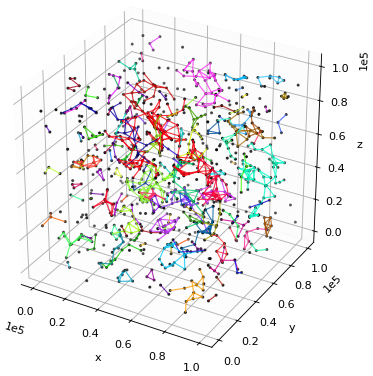

day08b

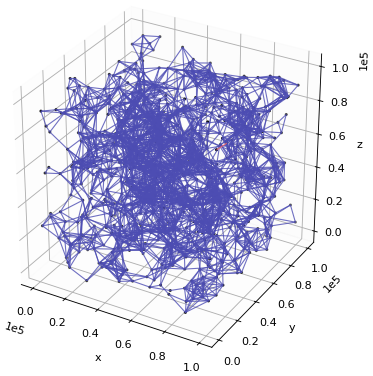

In [45]:
def day8_visualize(s, *, part2=False, num_edges=1000):
  points = np.array([list(map(int, line.split(','))) for line in s.splitlines()])
  dists = scipy.spatial.distance.pdist(points)
  sorted_indices = np.argsort(dists)[: None if part2 else num_edges]
  ij_of_index = np.column_stack(np.triu_indices(len(points), k=1))

  union_find = hh.UnionFind[int]()
  num_components = len(points)
  lines = []
  for edge_index in sorted_indices:
    i, j = ij_of_index[edge_index]
    lines.append([points[i], points[j]])
    label_i, label_j = union_find.find(i), union_find.find(j)
    if label_i != label_j:
      union_find.union(i, j)
      num_components -= 1
      if part2 and num_components == 1:
        break

  sorted_indices = sorted_indices[: len(lines)]
  labels = [union_find.find(i) for i in range(len(points))]
  unique_labels = list(set(labels))
  colors = hh.generate_random_colors(len(unique_labels), max_intensity=150) / 255
  colors[0] = 0.3, 0.3, 0.7
  color_of_label = {label: colors[i] for i, label in enumerate(unique_labels)}

  fig = plt.figure(figsize=(6, 6), dpi=80)
  ax: Any = fig.add_subplot(111, projection='3d')  # ax: mpl_toolkits.mplot3d.axes3d.Axes3D.
  ax.ticklabel_format(style='scientific', scilimits=(0, 0))
  ax.set(xlabel='x', ylabel='y', zlabel='z')
  ax.set_aspect('equal')
  for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis.pane.set_alpha(0.1)

  ax.scatter(*points.T, color='black', marker='o', s=3)

  line_colors = [color_of_label[labels[ij_of_index[index][0]]] for index in sorted_indices]
  if part2:
    line_colors[-1] = 1.0, 0.4, 0.4
  from mpl_toolkits.mplot3d.art3d import Line3DCollection

  ax.add_collection(Line3DCollection(lines, colors=line_colors, linewidths=1.0, alpha=0.8))

  image = hh.bounding_crop(hh.image_from_plt(fig), (255, 255, 255), margin=5)
  plt.close(fig)
  title = 'day08b' if part2 else 'day08a'
  media.show_image(image, title=title)


day8_visualize(puzzle.input)
day8_visualize(puzzle.input, part2=True)

<a name="day9"></a>
## Day 9: Largest rectangle

- Part 1: Using two red tiles as opposite corners, what is the largest area of any rectangle you can make?

- Part 2: The input files form a closed path.  Using two red tiles as opposite corners, what is the largest area of any rectangle you can make that does not go outside the closed path?

In [46]:
puzzle = advent.puzzle(day=9)

For [day 9](https://adventofcode.com/2025/day/9), `puzzle.input` has 496 lines:

97538,50203
97538,51426
98142,51426
98142,52612
97484,52612
97484,53823
97514,53823
97514,55016
 ...
97496,47795
97496,48991
97894,48991
97894,50203


The stored answers are: `{1: '4764078684', 2: '1652344888'}`

In [47]:
s1 = """\
7,1
11,1
11,7
9,7
9,5
2,5
2,3
7,3
"""

In [48]:
def day9a_part1(s):  # Simple and fast.
  points = [tuple(map(int, line.split(','))) for line in s.splitlines()]
  return max(
      (abs(x1 - x2) + 1) * (abs(y1 - y2) + 1)
      for (x1, y1), (x2, y2) in itertools.combinations(points, 2)
  )


check_eq(day9a_part1(s1), 50)
puzzle.verify(1, day9a_part1)

(Part 1: 0.014 s)


In [49]:
def _circular_pairwise(iterable):
  a, b = itertools.tee(iterable)
  first = next(b, None)
  return zip(a, itertools.chain(b, [first]))

In [50]:
def day9b(s, *, part2=False):
  points = [tuple(map(int, line.split(','))) for line in s.splitlines()]
  pairs = [
      (min(x1, x2), min(y1, y2), max(x1, x2), max(y1, y2))
      for (x1, y1), (x2, y2) in itertools.combinations(points, 2)
  ]

  def area(x1, y1, x2, y2):
    return (x2 - x1 + 1) * (y2 - y1 + 1)

  if not part2:
    return max(area(*pair) for pair in pairs)

  edges = [
      (min(x1, x2), min(y1, y2), max(x1, x2), max(y1, y2))
      for (x1, y1), (x2, y2) in itertools.pairwise(points + [points[0]])
  ]
  length = lambda p: p[2] - p[0] + p[3] - p[1]
  edges = sorted(edges, key=length, reverse=True)  # Optional, provides 4x speedup.

  return max(
      area(x1, y1, x2, y2)
      for x1, y1, x2, y2 in pairs
      if all(xx1 >= x2 or xx2 <= x1 or yy1 >= y2 or yy2 <= y1 for xx1, yy1, xx2, yy2 in edges)
  )


check_eq(day9b(s1), 50)
puzzle.verify(1, day9b)

day9b_part2 = functools.partial(day9b, part2=True)
check_eq(day9b_part2(s1), 24)
puzzle.verify(2, day9b_part2)

(Part 1: 0.049 s)
(Part 2: 0.190 s)


In [51]:
@numba.njit
def day9_jit(points, part2):
  n = len(points)
  pairs = np.empty((n * (n - 1) // 2, 4), dtype=points.dtype)
  index = 0
  for i in range(n):
    for j in range(i + 1, n):
      x1, y1, x2, y2 = points[i, 0], points[i, 1], points[j, 0], points[j, 1]
      pairs[index] = min(x1, x2), min(y1, y2), max(x1, x2), max(y1, y2)
      index += 1

  if not part2:
    return np.max((pairs[:, 2] - pairs[:, 0] + 1) * (pairs[:, 3] - pairs[:, 1] + 1))

  closed = np.vstack((points, points[:1]))
  edges: Any = np.empty((n, 4), dtype=points.dtype)
  edges[:, :2] = np.minimum(closed[:-1], closed[1:])
  edges[:, 2:] = np.maximum(closed[:-1], closed[1:])

  length = lambda p: p[2] - p[0] + p[3] - p[1]
  edges = sorted(edges, key=length, reverse=True)  # 4x speedup.

  def rectangle_overlaps_any_edge(x1, y1, x2, y2):
    for xx1, yy1, xx2, yy2 in edges:
      if xx1 < x2 and xx2 > x1 and yy1 < y2 and yy2 > y1:
        return True
    return False

  max_area = 0
  for x1, y1, x2, y2 in pairs:
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    if area > max_area and not rectangle_overlaps_any_edge(x1, y1, x2, y2):
      max_area = area
  return max_area


def day9(s, *, part2=False):
  points = np.array([tuple(map(int, line.split(','))) for line in s.splitlines()])
  return day9_jit(points, part2)


check_eq(day9(s1), 50)  # ~7s for jit!
puzzle.verify(1, day9)

day9_part2 = functools.partial(day9, part2=True)
check_eq(day9_part2(s1), 24)
puzzle.verify(2, day9_part2)

(Part 1: 0.005 s)
(Part 2: 0.001 s)


day09

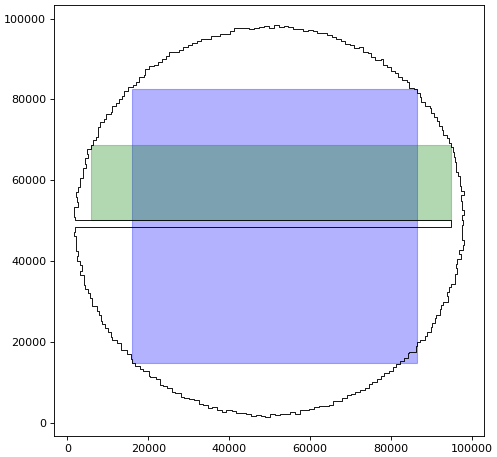

In [52]:
def day9_visualize(s):
  points = np.array([tuple(map(int, line.split(','))) for line in s.splitlines()])
  closed = np.vstack((points, points[:1]))
  pairs = [
      (min(x1, x2), min(y1, y2), max(x1, x2), max(y1, y2))
      for (x1, y1), (x2, y2) in itertools.combinations(points, 2)
  ]
  edges = [
      (min(x1, x2), min(y1, y2), max(x1, x2), max(y1, y2))
      for (x1, y1), (x2, y2) in itertools.pairwise(closed)
  ]
  length = lambda p: p[2] - p[0] + p[3] - p[1]
  edges = sorted(edges, key=length, reverse=True)  # 4x speedup.

  _, part1_pair = max(
      ((x2 - x1 + 1) * (y2 - y1 + 1), ((x1, y1), (x2, y2))) for x1, y1, x2, y2 in pairs
  )

  _, part2_pair = max(
      ((x2 - x1 + 1) * (y2 - y1 + 1), ((x1, y1), (x2, y2)))
      for x1, y1, x2, y2 in pairs
      if all(xx1 >= x2 or xx2 <= x1 or yy1 >= y2 or yy2 <= y1 for xx1, yy1, xx2, yy2 in edges)
  )

  fig, ax = plt.subplots(figsize=(7,) * 2, dpi=80)
  ax.set_aspect('equal')
  ax.plot(*closed.T, 'k-', linewidth=0.8)
  for ((x1, y1), (x2, y2)), color in [[part1_pair, 'blue'], [part2_pair, 'green']]:
    ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, color=color, alpha=0.3))
  image = hh.bounding_crop(hh.image_from_plt(fig), (255, 255, 255), margin=5)
  plt.close(fig)
  media.show_image(image, title='day09')


day9_visualize(puzzle.input)

<a name="day10"></a>
## Day 10: BFS and ILP

- Part 1: For each machine, each button toggles a subset of lights.  What is the fewest button presses required to correctly configure the indicator lights on all of the machines?

- Part 2: For each machine, each button instead increments a subset of counters.  What is the fewest button presses required to correctly configure the counters on all of the machines?

In [53]:
puzzle = advent.puzzle(day=10)

For [day 10](https://adventofcode.com/2025/day/10), `puzzle.input` has 167 lines:

[###.] (0,3) (0,2,3) (1,3) (0,1,3) {117,15,2,128}
[...##..] (2,3) (5,6) (0,1,3,4,5) (0,1,2,6) (2,3,4,5,6) (0,1,5) {12,12,13,13,2,31,19}
[.###.#..#.] (0,1,3,7,8) (0,1,2,3,4,6,7,9) (0,1,3,5,6,8,9) (3,8) (1,6,7,9) (2,8) ... ,8) {51,33,24,38,16,22,58,25,54,44}
[#.##] (0,1,2,3) (0,2,3) {9,1,9,9}
[##.###] (0,1,4,5) (0,1,3,5) (0,1,4) (2,3) (0,1,3,4,5) (1,3) {43,59,16,39,38,25}
[##.##.####] (2,6,8) (2,5,6,7,8,9) (0,1,6,7,8,9) (0,1,2,5,6,7,8,9) (3,4) (0,1,3, ... ,4) {24,40,67,26,42,34,62,64,81,64}
[##...#..#] (1,4,5,6,7) (0,2,3,4,5,6,8) (1,2,4,7,8) (0,2,5,6,8) (0,1,5,7) (1,3,6 ... 2,3,7) {44,44,44,36,12,42,46,36,27}
[##...] (2,3) (1,4) (0,1,3,4) (0,1,3) (0,1,4) (0,3,4) {32,32,0,21,27}
 ...
[.###.] (1,2,3) (4) (0,1,2,4) (1,4) (0,1,3) (0) (0,3) {42,43,31,29,33}
[.#..##.##.] (5,6,7,9) (4,7,8) (1,2,4,5,6,8,9) (1,2,4,5,7,9) (0,2,3,5,6,7,9) (0, ... ,5) {55,62,69,54,48,47,67,78,53,75}
[###..#] (0,2,4,5) (0,2,3) (0,3,5) (0,1,2,5) {58,13,41,25,20,50}
[#.###.####] (0,1,2,3,5,8) (2,5,9) (2,6,7,9) (0,1,5) 

The stored answers are: `{1: '461', 2: '16386'}`

In [54]:
s1 = """\
[.##.] (3) (1,3) (2) (2,3) (0,2) (0,1) {3,5,4,7}
[...#.] (0,2,3,4) (2,3) (0,4) (0,1,2) (1,2,3,4) {7,5,12,7,2}
[.###.#] (0,1,2,3,4) (0,3,4) (0,1,2,4,5) (1,2) {10,11,11,5,10,5}
"""

In [55]:
def day10_part1(s):  # Using breadth-first search.
  total = 0
  for line in s.splitlines():
    s_parts = line.split()
    desired = frozenset(i for i, ch in enumerate(s_parts[0][1:-1]) if ch == '#')
    changes = [set(map(int, re.findall(r'\d+', part))) for part in s_parts[1:-1]]

    def min_step_count_using_bfs():
      state = frozenset[int]()
      states = [state]
      visited = {state}
      for step in itertools.count(1):
        assert states
        new_states = []
        for state in states:
          for change in changes:
            new_state = frozenset(state ^ change)
            if new_state not in visited:
              if new_state == desired:
                return step
              visited.add(new_state)
              new_states.append(new_state)
        states = new_states

    total += min_step_count_using_bfs()

  return total


check_eq(day10_part1(s1), 7)
puzzle.verify(1, day10_part1)

(Part 1: 0.025 s)


In [56]:
def day10a_part2(s):  # Using the z3 solver.
  # The problem is an instance of integer linear programming (ILP), with the special case
  # of matrix M being a 0-1 matrix --- this may be a covering/packing style problem.

  def solve_min_sum_z3(M, b):
    """Solve min_x(1^T * x) s.t. x ∈ ℤ^n, x >= 0, and M * x = b."""
    solver = z3.Optimize()
    x = [z3.Int(f'x{i}') for i in range(len(M[0]))]

    # Non-negativity.
    for xi in x:
      solver.add(xi >= 0)

    # Constraints: M * x = b.
    for i, row in enumerate(M):
      # solver.add(z3.Sum([c * x[j] for j, c in enumerate(row) if c]) == b[i])
      assert all(c in {0, 1} for c in row)
      solver.add(z3.Sum([x[j] for j, c in enumerate(row) if c]) == b[i])

    # Minimize sum(x).
    solver.minimize(z3.Sum(x))

    assert solver.check() == z3.sat
    model = solver.model()
    return [model[xi].as_long() for xi in x]

  total = 0
  for line in s.splitlines():
    s_parts = line.split()
    changes = [set(map(int, re.findall(r'\d+', part))) for part in s_parts[1:-1]]
    b = list(map(int, re.findall(r'\d+', s_parts[-1])))
    M = [[int(i in change) for change in changes] for i in range(len(b))]
    x = solve_min_sum_z3(M, b)
    total += sum(x)

  return total


check_eq(day10a_part2(s1), 33)
puzzle.verify(2, day10a_part2)

(Part 2: 0.425 s)


In [57]:
def day10b_part2(s):  # Explore some small speedups with the z3 solver approach.
  # - Reusing the z3 solver across several lines gives 1.1x speedup.
  # - Sorting matrix columns by contribution gives 1.05x speedup.
  # - (Multiprocessing only gave another 1.1x speedup.)
  lines = s.splitlines()
  max_cols = max(len(line.split()) - 2 for line in lines)
  total = 0

  solver = z3.Optimize()
  x = z3.IntVector('x', max_cols)

  # Permanent constraints: non-negativity.
  for xi in x:
    solver.add(xi >= 0)

  for line in lines:
    s_parts = line.split()
    changes = [set(map(int, re.findall(r'\d+', part))) for part in s_parts[1:-1]]
    desired = list(map(int, re.findall(r'\d+', s_parts[-1])))
    if 0:  # No effect, but reverse=False is slower.
      coverage = [sum(i in ch for i in range(len(desired))) for ch in changes]
      order = sorted(range(len(changes)), key=lambda j: coverage[j], reverse=True)
      changes = [changes[j] for j in order]
    if 1:  # About 1.05x faster.
      contribution = [sum(desired[i] for i in range(len(desired)) if i in ch) for ch in changes]
      order = sorted(range(len(changes)), key=lambda j: contribution[j], reverse=False)
      changes = [changes[j] for j in order]

    solver.push()  # Save state.

    # Per-line constraints.
    for i, target in enumerate(desired):
      solver.add(z3.Sum([x[j] for j, ch in enumerate(changes) if i in ch]) == target)

    solver.minimize(z3.Sum(x[: len(changes)]))
    assert solver.check() == z3.sat
    total += sum(solver.model()[x[j]].as_long() for j in range(len(changes)))

    solver.pop()  # Restore state, removing per-line constraints.

  return total


check_eq(day10b_part2(s1), 33)
puzzle.verify(2, day10b_part2)

(Part 2: 0.362 s)


In [58]:
def day10_part2(s):  # Using scipy.optimize.milp().
  # I tried multiprocessing but it misbehaved due to the multithreading already in scipy.optimize.
  total = 0

  for line in s.splitlines():
    s_parts = line.split()
    changes = s_parts[1:-1]
    desired = np.array(list(map(int, re.findall(r'\d+', s_parts[-1]))), dtype=float)

    n_rows, n_cols = len(desired), len(changes)
    A = np.zeros((n_rows, n_cols))
    for j, change in enumerate(changes):
      for i in map(int, re.findall(r'\d+', change)):
        A[i, j] = 1.0

    # Equality constraints A x = desired.
    lc = scipy.optimize.LinearConstraint(A, desired, desired)

    # Objective: minimize sum(x).
    c = np.ones(n_cols)

    # Bounds: x_j ≥ 0, x_j ≤ +∞.
    lb = np.zeros(n_cols)
    ub = np.full(n_cols, np.inf)
    bounds = scipy.optimize.Bounds(lb, ub)

    # All variables are integers.
    integrality = np.ones(n_cols, dtype=int)

    result = scipy.optimize.milp(
        c=c,
        integrality=integrality,
        bounds=bounds,
        constraints=[lc],
        options={'disp': False},
    )
    assert result.success
    total += int(round(result.fun))

  return total


check_eq(day10_part2(s1), 33)
puzzle.verify(2, day10_part2)

(Part 2: 0.120 s)


<a name="day11"></a>
## Day 11: Count graph paths

- Part 1: How many different paths lead from `you` to `out`?

- Part 2: How many paths from `svr` to `out` visit both `dac` and `fft`?

In [59]:
puzzle = advent.puzzle(day=11)

For [day 11](https://adventofcode.com/2025/day/11), `puzzle.input` has 607 lines:

nxl: rqe jfg ife
gdt: bcf qyo bea rbl fsm qxe uri ath nav jjm bzs vbo
tqj: pgj mci
mzn: azn
tut: cix wzd jfv
rde: yyn mnd crn
frl: okl
wmb: hlf
 ...
urw: mbu ann wgg
wub: abz ufj
fsm: auf yzg
tzi: kdn yuh


The stored answers are: `{1: '662', 2: '429399933071120'}`

In [60]:
s1 = """\
aaa: you hhh
you: bbb ccc
bbb: ddd eee
ccc: ddd eee fff
ddd: ggg
eee: out
fff: out
ggg: out
hhh: ccc fff iii
iii: out
"""

In [61]:
s2 = """\
svr: aaa bbb
aaa: fft
fft: ccc
bbb: tty
tty: ccc
ccc: ddd eee
ddd: hub
hub: fff
eee: dac
dac: fff
fff: ggg hhh
ggg: out
hhh: out
"""

In [62]:
def day11(s, *, part2=False):
  # The solution assumes that the graph does not contain cycles!
  edges = {lhs: set(rhs.split()) for line in s.splitlines() for lhs, rhs in [line.split(': ')]}

  @functools.cache
  def get_count(node, num_special_visited):
    if node == 'out':
      return 1 if num_special_visited >= 2 else 0
    return sum(
        get_count(node2, num_special_visited + (node in {'dac', 'fft'})) for node2 in edges[node]
    )

  return get_count('svr', 0) if part2 else get_count('you', 2)


check_eq(day11(s1), 5)
puzzle.verify(1, day11)

day11_part2 = functools.partial(day11, part2=True)
check_eq(day11_part2(s2), 2)
puzzle.verify(2, day11_part2)

(Part 1: 0.000 s)
(Part 2: 0.001 s)


day11

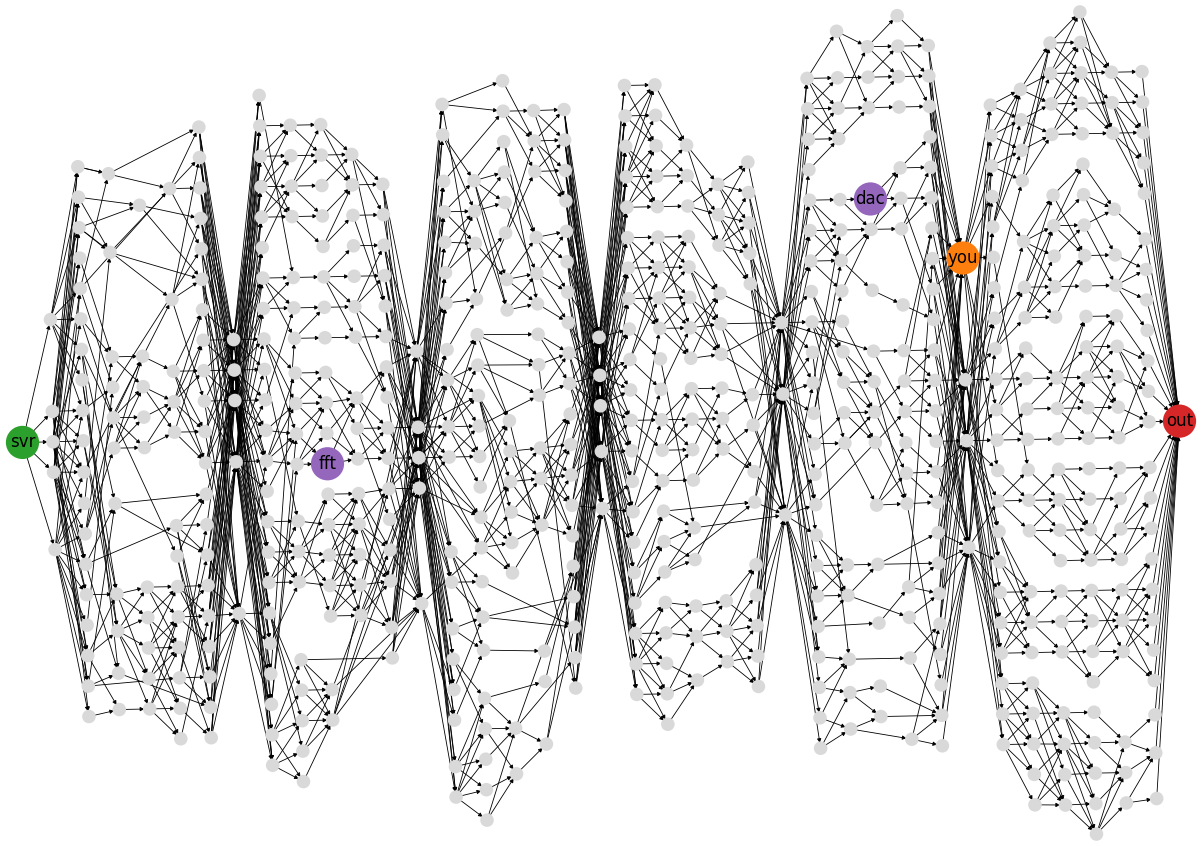

In [63]:
def day11_visualize(s):
  edges = {lhs: set(rhs.split()) for line in s.splitlines() for lhs, rhs in [line.split(': ')]}

  graph = networkx.DiGraph()
  for node1, adjacent in edges.items():
    for node2 in adjacent:
      graph.add_edge(node1, node2)

  pos = hh.graph_layout(graph, prog='dot')  # Or prog='neato'.
  pos = hh.rotate_layout_so_node_is_on_left(pos, 'out', math.tau / 2)
  fig, ax = plt.subplots(figsize=(7, 14), dpi=200)
  ax.set_aspect('equal')
  gray = (0.85,) * 3
  colors = dict(you='C1', svr='C2', out='C3', dac='C4', fft='C4')
  node_color = [colors.get(node, gray) for node in graph]
  labels = {node: node for node in graph if node in colors}
  node_size = [(120 if node in labels else 15) for node in graph]
  node_args = dict(node_size=node_size, node_color=node_color, labels=labels, font_size=6)
  networkx.draw(graph, pos, **node_args, width=0.3, arrowsize=3)
  fig.tight_layout(pad=0)
  image = hh.bounding_crop(hh.image_from_plt(fig), (255, 255, 255), margin=5)
  plt.close(fig)
  media.show_image(image, title='day11')


day11_visualize(puzzle.input)

<a name="day12"></a>
## Day 12: Tetris-like packing

- Part 1: How many of the regions can fit all of the presents listed?

- Part 2: No part 2 for last day.

In [64]:
puzzle = advent.puzzle(day=12)

For [day 12](https://adventofcode.com/2025/day/12), `puzzle.input` has 1_030 lines:

0:
##.
.##
..#

1:
###
##.
 ...
45x36: 24 27 44 22 29 33
44x38: 23 33 28 29 35 20
39x46: 54 42 43 49 39 51
46x40: 44 45 61 40 42 50


The stored answers are: `{1: '536', 2: None}`

In [65]:
s1 = """\
0:
###
##.
##.

1:
###
##.
.##

2:
.##
###
##.

3:
##.
###
##.

4:
###
#..
###

5:
###
.#.
###

4x4: 0 0 0 0 2 0
12x5: 1 0 1 0 2 2
12x5: 1 0 1 0 3 2
"""

In [66]:
if 0:
  print('\n'.join(f'    {line}' for line in puzzle.input.splitlines()[:32]))
  _ = """
    0:
    ##.
    .##
    ..#

    1:
    ###
    ##.
    #..

    2:
    #.#
    #.#
    ###

    3:
    ##.
    .##
    ###

    4:
    #.#
    ###
    #.#

    5:
    ##.
    ##.
    ###

    49x36: 50 58 46 32 38 51
    46x46: 44 43 34 34 28 41
  """

In [67]:
# This general packing problem is extremely difficult.
# Fortunately, it seems that all the specific problem instances (except `s1`) are easy.
# We can simply count the number of occupied grid cells in each shape.
def day12(s):
  sections = s.split('\n\n')
  shapes = []

  for s_shape in sections[:-1]:
    lines = s_shape.splitlines()
    shape = np.array([list(line) for line in lines[1:]]) == '#'
    shapes.append(shape)
  cell_count_of_shape = [np.sum(shape) for shape in shapes]

  total_feasible = 0
  for region_line in sections[-1].splitlines():
    fields = list(map(int, re.findall(r'\d+', region_line)))
    dims, counts = fields[:2], fields[2:]
    assert len(counts) == len(shapes)
    sum_cells = sum(cell_count_of_shape[i] * count for i, count in enumerate(counts))
    available_cells = dims[0] * dims[1]
    fraction = sum_cells / available_cells
    feasible = fraction <= 1.0
    # hh.show(dims, counts, sum_cells, available_cells, feasible, fraction)
    assert fraction < 0.8 or fraction > 1.0, fraction  # Easy problem instance.
    total_feasible += feasible

  return total_feasible


# check_eq(day12(s1), 2)  # The testcase itself is not an easy problem instance.
puzzle.verify(1, day12)

(Part 1: 0.003 s)


In [68]:
# puzzle.verify(2, lambda s: '')  # (No "Part 2" on last day.)

<a name="timings"></a>
## Timings

In [69]:
advent.show_times()

day_1    part_1: 0.001   part_2: 0.002
day_2    part_1: 0.000   part_2: 0.000
day_3    part_1: 0.002   part_2: 0.003
day_4    part_1: 0.002   part_2: 0.009
day_5    part_1: 0.001   part_2: 0.000
day_6    part_1: 0.002   part_2: 0.004
day_7    part_1: 0.004   part_2: 0.016
day_8    part_1: 0.019   part_2: 0.033
day_9    part_1: 0.005   part_2: 0.001
day_10   part_1: 0.025   part_2: 0.120
day_11   part_1: 0.000   part_2: 0.001
day_12   part_1: 0.003   part_2:-0.000
Total time:  0.255 s


In [70]:
if 0:  # Compute min execution times over several calls.
  advent.show_times(recompute=True, repeat=3)

In [71]:
if 1:  # Look for unwanted pollution of namespace.
  for _name in globals().copy():
    if not (re.match(r'^(_.*|(day|Day)\d+.*|s\d+|puzzle)$', _name) or _name in _ORIGINAL_GLOBALS):
      print(_name)

In [72]:
if 0:  # Lint.
  hh.run('echo pyink; pyink --diff .')
  hh.run('echo autopep8; autopep8 -j8 -d .')
  hh.run('echo mypy; mypy . || true')
  hh.run('echo pylint; pylint -j8 . || true')
  hh.run('echo pytype; pytype -j auto -k .')
  hh.run(
      'echo flake8; flake8 --indent-size=2 --exclude .ipynb_checkpoints'
      ' --extend-ignore E129,E203,E302,E305,E501,E741'
  )

In [73]:
hh.show_notebook_cell_top_times()

# Total time: 18.83 s
# In[ 51] @numba.njit\ndef day9_jit(points, part2):\n  n = len(        7.137 s
# In[ 63] def day11_visualize(s):\n  edges = {lhs: set(rhs.split())    4.442 s
# In[ 41] def day7_visualize(s, rep=3, fps=30):\n  grid = np.array([   1.257 s
# In[ 19] # Arithmetic solution.  E.g., a 6-digit value consists of    0.610 s
# In[ 56] def day10a_part2(s):  # Using the z3 solver.\n  # The        0.543 s
# In[ 45] def day8_visualize(s, *, part2=False, num_edges=1000):\n     0.490 s
# In[ 29] def day4_visualize(s, rep=2, fps=10):\n  grid = np.pad(np.   0.480 s
# In[ 57] def day10b_part2(s):  # Explore some small speedups with     0.466 s
# In[ 52] def day9_visualize(s):\n  points = np.array([tuple(map(int,  0.427 s
# In[ 50] def day9b(s, *, part2=False):\n  points = [tuple(map(int,    0.409 s
# In[ 58] def day10_part2(s):  # Using scipy.optimize.milp().\n  # I   0.224 s
# In[ 44] def day8(s, *, part2=False, num_edges=1000):\n  points =     0.217 s
# In[ 62] def day11(s, *, part

# End

<!-- For Emacs:
Local Variables:
fill-column: 100
End:
-->